# Notebook Description

In this notebook, I attempt to use machine learning to predict whether or not a golfer will make the cut at the Masters Tournament. The models used take inputs consisting of full season aggregate statistics from the previous year to make the predictions for that year's Masters Tournament (e.g., the models used 2018 full season data to predict 2019 results.

Additionally, we will use the subset of golfers that make the cut to attempt to predict the top 10 come Sunday evening at Augusta using regression.

# Necessary Packages and Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Webscrapping
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

# Regression
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Classification
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Pipeline
from sklearn.pipeline import Pipeline

# Class imbalance
from imblearn.over_sampling import SMOTE

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Dimesionality reduction
from sklearn.decomposition import PCA
pca = PCA()

# Graphing
%matplotlib inline
sns.set_style('darkgrid')
figsize = (15,8)
hspace = 0.5

# Pickling
import pickle
from sklearn.externals import joblib

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Helper Functions

## Webscrapping

In [2]:
# PGATour.com Webscrapping Function
def get_PGA_Tour_data(stats, seasons):

    """
    This function pings the PGA Tour's server and gathers the desired statistics
    (by inserting the stat_id into the url) and appends it to our data container
    """

    data = []
    
    for season in seasons:  
        print(f"Beginning {season} season:")
        for stat in stats: 
            url = f"https://www.pgatour.com/content/pgatour/stats/stat.{stat['stat_id']}.y{season}.html"

            #opening up connection, grabbing the page
            uClient = uReq(url)
            page_html = uClient.read()

            #html parsing using BeautifulSoup
            page_soup = soup(page_html, 'html.parser')

            #find the table where stats are kept
            tbody = page_soup.find('tbody')

            #each golfer is separated by a <tr> tag
            raw_golfers = tbody.findAll('tr')

            #loop through each golfer, grab name and avg. distance
            for raw_golfer in raw_golfers:
                golfer = {}
                golfer['season'] = season            
                name = raw_golfer.find('td', {'class':'player-name'}).a.text
                golfer['full_name'] = name.replace(' ', '_').lower()
                golfer[f"{stat['stat_name']}"] = raw_golfer.find('td', {'class':None}).text
                data.append(golfer)
            print(f" {stat['stat_name']} stats added for the {season} season")
        print(f"{season} season completed.\n")

    #close the client
    uClient.close()

    return data

## Convert Strings to Feet

In [3]:
# Convert stats to feet function
def convert_to_feet(x):
    """
    This function takes in a string and returns a float
    """
    
    if type(x) == str:
        y = x.replace("'","").replace('"',"").split()

        if len(y) == 1:
            y.extend([0])
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

        else:
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

    else:
        return np.nan

## Format Golfer

In [4]:
# Format golfer names from results Dataframe
def format_golfer(x):
    return x.replace(' ','_').lower()

## Plotter Functions

### Confusion Matrix Plotter

In [5]:
# creates the confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Greens
    fig = plt.figure(figsize=(5,4));
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")


    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

### Feature Importance Plotter

In [6]:
# creates feature importance graphs
def plot_feature_importances(X_train, model, n_features, FI_labels):
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center', fc='yellow', ec='darkgreen') 
    plt.yticks(np.arange(n_features), FI_labels) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

### Regression Results Plotter

In [7]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets"""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

# Data Gathering and Cleaning

## Data Gathering

### Desired Features

In [ ]:
# # The stat_id will be inserted into the url for each ping
# stats = [
#     {'stat_name': 'driving_distance',
#      'stat_id': '101'},
#     {'stat_name': 'driving_accuracy', 
#      'stat_id': '102'},
#     {'stat_name': 'greens_in_regulation', 
#      'stat_id': '103'},
#     {'stat_name': 'proximity', 
#      'stat_id': '331'},
#     {'stat_name': 'scrambling_rough',  
#      'stat_id': '363'},
#     {'stat_name': 'scrambling_sand',  
#      'stat_id': '362'},
#     {'stat_name': 'putting_conversion',
#      'stat_id': '115'},
#     {'stat_name': 'putting_rating',
#      'stat_id': '402'},
#     {'stat_name': 'sg_off_tee',
#      'stat_id': '02567'},
#     {'stat_name': 'sg_approach',
#      'stat_id': '02568'},
#     {'stat_name': 'sg_scrambling',  
#      'stat_id': '02569'},
#     {'stat_name': 'sg_putting',
#      'stat_id': '02564'},
#     {'stat_name': 'sg_tee_to_green',  
#      'stat_id': '02674'},
#     {'stat_name': 'sg_total',  
#      'stat_id': '02675'},
#     {'stat_name': 'scoring_avg',  
#      'stat_id': '120'},
# ]

### Seasons Considered

In [ ]:
# # Since strokes_gained stats only go back to 2004, we will consider 2004-2019
# seasons = range(2004, 2020)

### Webscrapping and Dataframe Conversion

In [ ]:
# # Call the web scrapping helper function defined above. Save the results and examine Dataframe
# data = get_PGA_Tour_data(stats, seasons)

In [ ]:
# # Convert data to Dataframe and save raw data locally
# df = pd.DataFrame(data)
# df.to_csv('csv_files/raw_golfer_data.csv')

## Data Cleaning

### Convert Features

In [8]:
# Reload raw data and examine dataframe
df = pd.read_csv('csv_files/raw_golfer_data.csv', index_col=0)
df.drop('str_diff_to_field', axis=1, inplace=True)
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(48592, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,hank_kuehne,314.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004,scott_hend,312.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004,john_daly,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,mike_heinen,305.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,chris_smith,304.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Convert proximity to feet floats and str_diff_to_field to stroke floats
df['proximity'] = df['proximity'].apply(lambda x: convert_to_feet(x))

# Convert percentage features to decimals
df['driving_accuracy'] = df['driving_accuracy']/100
df['greens_in_regulation'] = df['greens_in_regulation']/100
df['scrambling_rough'] = df['scrambling_rough']/100
df['scrambling_sand'] = df['scrambling_sand']/100
df['putting_conversion'] = df['putting_conversion']/100

### Groupby Season and Golfer

In [10]:
# Group stats by season and golfer
df = df.groupby(['season', 'full_name'])[
    'driving_distance','driving_accuracy','greens_in_regulation','proximity',
    'scrambling_rough','scrambling_sand','putting_conversion','putting_rating',
    'sg_off_tee','sg_approach','sg_scrambling','sg_putting','sg_tee_to_green',
    'sg_total','scoring_avg'].mean()

# Save grouped data locally
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine data
df = pd.read_csv('csv_files/golfer_data.csv')

print(df.shape)
df.head()

(3036, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,aaron_baddeley,288.0,0.5308,0.5817,39.333333,0.5769,0.5351,0.3015,1.576,-0.530,-0.679,0.201,0.579,-1.008,-0.429,71.614
1,2004,adam_scott,295.4,0.5765,0.6560,35.333333,0.5301,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
2,2004,alex_cejka,285.8,0.6421,0.6381,36.083333,0.5108,0.5765,0.2877,1.625,0.119,0.255,0.020,-0.006,0.394,0.388,71.153
3,2004,andre_stolz,297.9,0.5897,0.6300,36.416667,0.4632,0.5244,0.2838,1.628,-0.333,-0.532,-0.137,-0.246,-1.002,-1.247,72.341
4,2004,arjun_atwal,289.4,0.6048,0.6252,35.916667,0.5979,0.4107,0.2980,1.606,0.013,-0.097,-0.116,-0.034,-0.200,-0.234,71.688


### Add Missing Golfers

In [11]:
# Import new csv file that contains data on missing golfers
missing = pd.read_csv('csv_files/masters_results - missing.csv')

print(missing.shape)
missing.head()

(27, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,trevor_immelman,282.3,63.89,60.34,"36' 5""",50.85,48.48,25.45,1.633,0.057,0.282,-0.031,-1.020,0.308,0.207,71.224
1,2005,ángel_cabrera,311.2,53.30,63.33,"37' 10""",54.29,47.50,29.03,1.665,0.531,0.067,0.141,-0.136,0.739,0.603,70.669
2,2006,paul_casey,305.3,62.66,67.17,"32' 1""",45.00,53.57,26.42,1.707,0.118,1.385,-0.249,-0.641,1.254,0.613,70.837
3,2007,andres_romero,312.5,56.25,58.89,"33' 10""",76.47,62.16,26.42,1.572,1.988,-0.457,0.342,0.416,1.873,2.289,68.653
4,2007,robert_karlsson,298.9,51.02,57.54,"36' 2""",51.55,44.44,27.36,1.631,-0.130,-0.219,-0.025,-0.374,-0.022,-0.396,71.396


In [12]:
# Convert the features of missing golfers
missing['proximity'] = missing['proximity'].apply(lambda x: convert_to_feet(x))

# Convert percentage features to decimals
missing['driving_accuracy'] = missing['driving_accuracy']/100
missing['greens_in_regulation'] = missing['greens_in_regulation']/100
missing['scrambling_rough'] = missing['scrambling_rough']/100
missing['scrambling_sand'] = missing['scrambling_sand']/100
missing['putting_conversion'] = missing['putting_conversion']/100

In [13]:
concat = [df, missing]
df = pd.concat(concat)

In [14]:
df.sort_values(by=['season', 'full_name'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(3063, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,aaron_baddeley,288.0,0.5308,0.5817,39.333333,0.5769,0.5351,0.3015,1.576,-0.530,-0.679,0.201,0.579,-1.008,-0.429,71.614
1,2004,adam_scott,295.4,0.5765,0.6560,35.333333,0.5301,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
2,2004,alex_cejka,285.8,0.6421,0.6381,36.083333,0.5108,0.5765,0.2877,1.625,0.119,0.255,0.020,-0.006,0.394,0.388,71.153
3,2004,andre_stolz,297.9,0.5897,0.6300,36.416667,0.4632,0.5244,0.2838,1.628,-0.333,-0.532,-0.137,-0.246,-1.002,-1.247,72.341
4,2004,arjun_atwal,289.4,0.6048,0.6252,35.916667,0.5979,0.4107,0.2980,1.606,0.013,-0.097,-0.116,-0.034,-0.200,-0.234,71.688


### Incorporate Historical Tournament Data

In [15]:
# Load Masters Results data and format each golfer to match our data's format
masters_results = pd.read_csv('csv_files/masters_results - data.csv')
masters_results['full_name'] = masters_results['full_name'].apply(lambda x: format_golfer(x))
masters_results = masters_results.sort_values(by=['masters_year', 'full_name'])

print(masters_results.shape)
masters_results.head()

(1469, 10)


,masters_year,full_name,total_score,prior_score,roll_5yr_majors,roll_3yr_majors,roll_1yr_majors,made_cut,top_10,champion
0,2005,adam_scott,294,315,0,0,0,1,0,0
2,2005,austin_eaton_iii,315,315,0,0,0,0,0,0
3,2005,ben_crenshaw,315,315,0,0,0,0,0,0
4,2005,ben_curtis,315,315,1,1,0,0,0,0
5,2005,bernhard_langer,289,285,0,0,0,1,0,0


In [16]:
# Merge dataframes together on name
df = pd.merge(df, masters_results, how='left', on='full_name')

# Drop Nans
df.dropna(inplace=True)

# Only consider rows where golfer participated the following masters
df = df[df['masters_year']-df['season'] == 1]

# Drop Masters year and reset Index
df.drop('masters_year', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Change floats to integers
df['made_cut'] = df['made_cut'].astype(int)
df['top_10'] = df['top_10'].astype(int)
df['champion'] = df['champion'].astype(int)
df['total_score'] = df['total_score'].astype(int)
df['prior_score'] = df['prior_score'].astype(int)
df['roll_5yr_majors'] = df['roll_5yr_majors'].astype(int)
df['roll_3yr_majors'] = df['roll_3yr_majors'].astype(int)
df['roll_1yr_majors'] = df['roll_1yr_majors'].astype(int)

# Feature Engineering

## Rolling Majors

In [17]:
df['exp_5'] = np.exp(df['roll_5yr_majors']*1)
df['exp_3'] = np.exp(df['roll_3yr_majors']*5)
df['exp_1'] = np.exp(df['roll_1yr_majors']*10)
df['rolling_majors'] = df['exp_5']*df['exp_3']*df['exp_1']
df['rolling_majors'] = np.log(df['rolling_majors'])

## Birdie or Better Distance
Generate a circle where the radius equals a golfer's maximum distance from the hole in which the golfer will make a birdie or better from

In [18]:
df['otg_area'] = df['proximity']**2 * np.pi
df['bob_area'] = df['otg_area']*df['putting_conversion']
df['bob_distance'] = np.sqrt(df['bob_area']/np.pi)
df.drop(['proximity', 'putting_conversion',
         'otg_area', 'bob_area'], axis=1, inplace=True)

## Field Average Score
Create a column that is the average score of the field that year for each golfer

In [19]:
# Reorder dataframe so that it is sorted by golfer and than seaon
df = df.groupby(['full_name', 'season'])['champion', 'top_10', 'made_cut', 'total_score', 'prior_score',
        'roll_5yr_majors', 'roll_3yr_majors', 'roll_1yr_majors', 'rolling_majors',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'bob_distance',
        'scrambling_rough', 'scrambling_sand', 'putting_rating', 'scoring_avg', 
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green', 'sg_total'].mean()

# Save and reload csv
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine dataframe
df = pd.read_csv('csv_files/golfer_data.csv')

In [20]:
# Get each year's Masters Tournament average score for the field
hist_scores = pd.DataFrame(df.groupby('season')['prior_score'].mean())
hist_scores.reset_index(drop=False, inplace=True)
hist_scores['prior_afs'] = hist_scores['prior_score'].astype(int)
hist_scores.drop('prior_score', axis=1, inplace=True)

# Merge with our dataframe
df = pd.merge(df, hist_scores, how='inner', on='season')

## Strokes Gained On Field
Create a new column that calculates how much better (or worse) the golfer did than the field average that year

In [21]:
# Create column
df['sg_on_field'] = df['prior_afs']-df['prior_score']

# Reorder dataframe so that it is sorted by golfer and than seaon
df = df.groupby(['full_name', 'season'])['champion', 'top_10', 'made_cut',
        'total_score', 'prior_score', 'prior_afs', 'sg_on_field',
        'roll_5yr_majors', 'roll_3yr_majors', 'roll_1yr_majors', 'rolling_majors',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'bob_distance',
        'scrambling_rough', 'scrambling_sand', 'putting_rating', 'scoring_avg',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green', 'sg_total'].mean()

# Save and reload csv
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine dataframe
df = pd.read_csv('csv_files/golfer_data.csv')

## Experience and Rolling Averages

In [22]:
# Generate a list of unique golfers and nan values to poulate 2019
golfers = df['full_name'].unique().tolist()

# Create a list of dictionaries to house each golfers prior score at the Masters for every year
names_and_scores = []
for golfer in golfers:
    name_and_scores = {}
    name_and_scores['golfer'] = golfer
    prior_scores = []
    strokes_gained_on_field = []
    for i in range(df.shape[0]):
        if golfer == df['full_name'].iloc[i]:
            prior_scores.append(df['prior_score'].iloc[i])
            strokes_gained_on_field.append(df['sg_on_field'].iloc[i])
        else:
            continue
    name_and_scores['prior_scores'] = prior_scores
    name_and_scores['strokes_gained_on_field'] = strokes_gained_on_field
    names_and_scores.append(name_and_scores)

# Loop through list of dictionaries and create a rolling avg of prior scores list for each golfer
for golfer in names_and_scores:
    prior_scores_rolling_avg = []
    strokes_gained_rolling_avg = []
    experiences = []
    i = 1
    while i <= len(golfer['prior_scores']):
        prior_score_rolling_avg = np.mean(golfer['prior_scores'][:i])
        prior_scores_rolling_avg.append(prior_score_rolling_avg)
        sg_rolling_avg = np.mean(golfer['strokes_gained_on_field'][:i])
        strokes_gained_rolling_avg.append(sg_rolling_avg)
        experience = len(prior_scores_rolling_avg)
        experiences.append(experience)
        i += 1
    golfer['ps_roll_avg'] = prior_scores_rolling_avg
    golfer['sg_roll_avg'] = strokes_gained_rolling_avg
    golfer['experience'] = experiences

# Join all of the sepearate lists together
prior_scores_rolling_avg = []
strokes_gained_rolling_avg = []
experiences = []
for golfer in names_and_scores:
    prior_scores_rolling_avg.extend(golfer['ps_roll_avg'])
    strokes_gained_rolling_avg.extend(golfer['sg_roll_avg'])
    experiences.extend(golfer['experience'])

# Add to our dataframe
df['experience'] = experiences
df['ps_roll_avg'] = prior_scores_rolling_avg
df['sg_roll_avg'] = strokes_gained_rolling_avg

## Strokes Gained Statistic

In [23]:
# Create feature to account for relationship between sg stats
df['sg_stat'] = np.exp(df['sg_off_tee']*df['sg_approach']*df['sg_scrambling']*
                    df['sg_putting']*df['sg_tee_to_green']*df['sg_total'])
                
# Account for sign (+/-)
for i in range(df.shape[0]):
    if df['sg_total'].iloc[i] < 0:
        df['sg_stat'].iloc[i] = df['sg_stat'].iloc[i]*-1
    else:
        continue

# Reorder and examine dataframe
cols = ['full_name', 'season', 'experience', 'champion', 'top_10', 'made_cut',
        'total_score', 'prior_score', 'ps_roll_avg', 'prior_afs', 'sg_on_field',
        'sg_roll_avg', 'rolling_majors',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'bob_distance',
        'scrambling_rough', 'scrambling_sand', 'putting_rating', 'scoring_avg', 'sg_stat']

df = df[cols]

print(df.shape)
df.head()

(951, 22)


/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,full_name,season,experience,champion,top_10,made_cut,total_score,prior_score,ps_roll_avg,prior_afs,...,rolling_majors,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,sg_stat
0,aaron_baddeley,2006,1,0,0,1,307,315,315.000000,302,...,0.0,288.3,0.6073,0.5826,21.326667,0.6100,0.5271,1.553,71.197,0.999697
1,aaron_baddeley,2007,2,0,0,0,315,307,311.000000,305,...,0.0,291.9,0.6000,0.6035,21.005830,0.6021,0.5905,1.570,70.088,0.994052
2,aaron_baddeley,2008,3,0,0,1,284,315,312.333333,302,...,0.0,290.3,0.5945,0.6202,21.109307,0.5549,0.5694,1.577,70.196,0.999667
3,aaron_baddeley,2010,4,0,0,1,293,315,313.000000,300,...,0.0,298.9,0.5665,0.6460,21.237521,0.5458,0.5766,1.587,70.995,1.001072
4,aaron_baddeley,2011,5,0,0,1,293,293,309.000000,299,...,0.0,296.2,0.5567,0.6548,21.490982,0.4932,0.5673,1.536,70.230,1.005012


# Holdout Sets

## 2009

In [24]:
# Create holdout and testing datasets for 2009 data
holdout_2009 = df[df['season'] == 2009]
test_df_2009 = df[(df['season'] < 2009)]

# Save both the holdout and validation set locally
holdout_2009.to_csv('csv_files/holdouts/2009/holdout_data.csv')
test_df_2009.to_csv('csv_files/holdouts/2009/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2009.shape}')
print(f'Testing Data: {test_df_2009.shape}')

Holdout Set: (57, 22)
Testing Data: (304, 22)


## 2010

In [25]:
# Create holdout and testing datasets for 2010 data
holdout_2010 = df[df['season'] == 2010]
test_df_2010 = df[(df['season'] < 2010)]

# Save both the holdout and validation set locally
holdout_2010.to_csv('csv_files/holdouts/2010/holdout_data.csv')
test_df_2010.to_csv('csv_files/holdouts/2010/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2010.shape}')
print(f'Testing Data: {test_df_2010.shape}')

Holdout Set: (62, 22)
Testing Data: (361, 22)


## 2011

In [26]:
# Create holdout and testing datasets for 2011 data
holdout_2011 = df[df['season'] == 2011]
test_df_2011 = df[(df['season'] < 2011)]

# Save both the holdout and validation set locally
holdout_2011.to_csv('csv_files/holdouts/2011/holdout_data.csv')
test_df_2011.to_csv('csv_files/holdouts/2011/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2011.shape}')
print(f'Testing Data: {test_df_2011.shape}')

Holdout Set: (59, 22)
Testing Data: (423, 22)


## 2012

In [27]:
# Create holdout and testing datasets for 2012 data
holdout_2012 = df[df['season'] == 2012]
test_df_2012 = df[(df['season'] < 2012)]

# Save both the holdout and validation set locally
holdout_2012.to_csv('csv_files/holdouts/2012/holdout_data.csv')
test_df_2012.to_csv('csv_files/holdouts/2012/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2012.shape}')
print(f'Testing Data: {test_df_2012.shape}')

Holdout Set: (57, 22)
Testing Data: (482, 22)


## 2013

In [28]:
# Create holdout and testing datasets for 2013 data
holdout_2013 = df[df['season'] == 2013]
test_df_2013 = df[(df['season'] < 2013)]

# Save both the holdout and validation set locally
holdout_2013.to_csv('csv_files/holdouts/2013/holdout_data.csv')
test_df_2013.to_csv('csv_files/holdouts/2013/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2013.shape}')
print(f'Testing Data: {test_df_2013.shape}')

Holdout Set: (66, 22)
Testing Data: (539, 22)


## 2014

In [29]:
# Create holdout and testing datasets for 2014 data
holdout_2014 = df[df['season'] == 2014]
test_df_2014 = df[(df['season'] < 2014)]

# Save both the holdout and validation set locally
holdout_2014.to_csv('csv_files/holdouts/2014/holdout_data.csv')
test_df_2014.to_csv('csv_files/holdouts/2014/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2014.shape}')
print(f'Testing Data: {test_df_2014.shape}')

Holdout Set: (65, 22)
Testing Data: (605, 22)


## 2015

In [30]:
# Create holdout and testing datasets for 2015 data
holdout_2015 = df[df['season'] == 2015]
test_df_2015 = df[(df['season'] < 2015)]

# Save both the holdout and validation set locally
holdout_2015.to_csv('csv_files/holdouts/2015/holdout_data.csv')
test_df_2015.to_csv('csv_files/holdouts/2015/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2015.shape}')
print(f'Testing Data: {test_df_2015.shape}')

Holdout Set: (57, 22)
Testing Data: (670, 22)


## 2016

In [31]:
# Create holdout and testing datasets for 2016 data
holdout_2016 = df[df['season'] == 2016]
test_df_2016 = df[(df['season'] < 2016)]

# Save both the holdout and validation set locally
holdout_2016.to_csv('csv_files/holdouts/2016/holdout_data.csv')
test_df_2016.to_csv('csv_files/holdouts/2016/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2016.shape}')
print(f'Testing Data: {test_df_2016.shape}')

Holdout Set: (57, 22)
Testing Data: (727, 22)


## 2017

In [32]:
# Create holdout and testing datasets for 2017 data
holdout_2017 = df[df['season'] == 2017]
test_df_2017 = df[(df['season'] < 2017)]

# Save both the holdout and validation set locally
holdout_2017.to_csv('csv_files/holdouts/2017/holdout_data.csv')
test_df_2017.to_csv('csv_files/holdouts/2017/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2017.shape}')
print(f'Testing Data: {test_df_2017.shape}')

Holdout Set: (52, 22)
Testing Data: (784, 22)


## 2018

In [33]:
# Create holdout and testing datasets for 2018 data
holdout_2018 = df[df['season'] == 2018]
test_df_2018 = df[(df['season'] < 2018)]

# Save both the holdout and validation set locally
holdout_2018.to_csv('csv_files/holdouts/2018/holdout_data.csv')
test_df_2018.to_csv('csv_files/holdouts/2018/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2018.shape}')
print(f'Testing Data: {test_df_2018.shape}')

Holdout Set: (59, 22)
Testing Data: (836, 22)


## 2019

In [34]:
# Create holdout and testing datasets for 2019 data
holdout_2019 = df[df['season'] == 2019]
test_df_2019 = df[(df['season'] < 2019)]

# Save both the holdout and validation set locally
holdout_2019.to_csv('csv_files/holdouts/2019/holdout_data.csv')
test_df_2019.to_csv('csv_files/holdouts/2019/test_df_data.csv')

# Examine sizes
print(f'Holdout Set: {holdout_2019.shape}')
print(f'Testing Data: {test_df_2019.shape}')

Holdout Set: (56, 22)
Testing Data: (895, 22)


# Exploratory Data Analysis

## General Information

In [35]:
df = pd.read_csv('csv_files/holdouts/2019/test_df_data.csv', index_col=0)

print(df.shape)
df.head(10)

(895, 22)


,full_name,season,experience,champion,top_10,made_cut,total_score,prior_score,ps_roll_avg,prior_afs,...,rolling_majors,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,sg_stat
0,aaron_baddeley,2006,1,0,0,1,307,315,315.000000,302,...,0.0,288.3,0.6073,0.5826,21.326667,0.6100,0.5271,1.553,71.197,0.999697
1,aaron_baddeley,2007,2,0,0,0,315,307,311.000000,305,...,0.0,291.9,0.6000,0.6035,21.005830,0.6021,0.5905,1.570,70.088,0.994052
2,aaron_baddeley,2008,3,0,0,1,284,315,312.333333,302,...,0.0,290.3,0.5945,0.6202,21.109307,0.5549,0.5694,1.577,70.196,0.999667
3,aaron_baddeley,2010,4,0,0,1,293,315,313.000000,300,...,0.0,298.9,0.5665,0.6460,21.237521,0.5458,0.5766,1.587,70.995,1.001072
4,aaron_baddeley,2011,5,0,0,1,293,293,309.000000,299,...,0.0,296.2,0.5567,0.6548,21.490982,0.4932,0.5673,1.536,70.230,1.005012
5,aaron_wise,2018,1,0,0,1,281,315,315.000000,295,...,0.0,302.9,0.6333,0.6881,20.845250,0.5668,0.4257,1.619,70.247,1.000016
7,adam_hadwin,2016,1,0,0,1,294,315,315.000000,304,...,0.0,290.1,0.6362,0.6607,20.325521,0.5714,0.5556,1.586,70.719,0.999997
8,adam_hadwin,2017,2,0,0,1,287,294,304.500000,299,...,0.0,291.3,0.6320,0.6508,20.035188,0.6000,0.6607,1.587,70.583,0.999999
9,adam_scott,2004,1,0,0,1,294,315,315.000000,303,...,0.0,295.4,0.5765,0.6560,20.266678,0.5301,0.6170,1.611,70.096,0.989345
10,adam_scott,2005,2,0,0,1,292,294,304.500000,303,...,0.0,300.1,0.5740,0.6724,17.385582,0.6047,0.4286,1.635,70.198,1.000103


In [36]:
top10 = df[df['top_10'] == 1]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 950
Data columns (total 22 columns):
full_name               895 non-null object
season                  895 non-null int64
experience              895 non-null int64
champion                895 non-null int64
top_10                  895 non-null int64
made_cut                895 non-null int64
total_score             895 non-null int64
prior_score             895 non-null int64
ps_roll_avg             895 non-null float64
prior_afs               895 non-null int64
sg_on_field             895 non-null int64
sg_roll_avg             895 non-null float64
rolling_majors          895 non-null float64
driving_distance        895 non-null float64
driving_accuracy        895 non-null float64
greens_in_regulation    895 non-null float64
bob_distance            895 non-null float64
scrambling_rough        895 non-null float64
scrambling_sand         895 non-null float64
putting_rating          895 non-null float64
scoring_avg   

In [38]:
top10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 15 to 946
Data columns (total 22 columns):
full_name               159 non-null object
season                  159 non-null int64
experience              159 non-null int64
champion                159 non-null int64
top_10                  159 non-null int64
made_cut                159 non-null int64
total_score             159 non-null int64
prior_score             159 non-null int64
ps_roll_avg             159 non-null float64
prior_afs               159 non-null int64
sg_on_field             159 non-null int64
sg_roll_avg             159 non-null float64
rolling_majors          159 non-null float64
driving_distance        159 non-null float64
driving_accuracy        159 non-null float64
greens_in_regulation    159 non-null float64
bob_distance            159 non-null float64
scrambling_rough        159 non-null float64
scrambling_sand         159 non-null float64
putting_rating          159 non-null float64
scoring_avg  

In [39]:
df.drop(['season', 'champion', 'top_10',
         'made_cut', 'total_score'],axis=1).describe()

,experience,prior_score,ps_roll_avg,prior_afs,sg_on_field,sg_roll_avg,rolling_majors,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,sg_stat
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,8.950000e+02
mean,3.778771,300.954190,303.180330,300.543017,-0.411173,-1.966711,1.563128,292.145251,0.620209,0.659189,19.249806,0.571287,0.532882,1.609478,70.377980,-2.414868e+08
std,2.932918,13.915176,9.628625,3.066762,13.572273,9.803162,4.997111,8.971336,0.049987,0.027971,1.128083,0.051435,0.073888,0.034899,0.653111,7.224452e+09
min,1.000000,274.000000,279.000000,295.000000,-20.000000,-20.000000,0.000000,268.500000,0.483100,0.543300,15.612389,0.434800,0.250000,1.430000,67.646000,-2.161307e+11
25%,1.000000,288.000000,295.535714,299.000000,-13.000000,-12.000000,0.000000,285.700000,0.585300,0.642200,18.500484,0.538500,0.484200,1.591000,70.018500,9.974600e-01
50%,3.000000,298.000000,302.333333,300.000000,3.000000,-1.000000,0.000000,292.000000,0.619700,0.660800,19.227367,0.571400,0.538500,1.611000,70.368000,9.999609e-01
75%,5.000000,315.000000,315.000000,303.000000,12.000000,5.666667,0.000000,298.100000,0.649800,0.678350,19.954849,0.603900,0.582400,1.633000,70.767500,1.000468e+00
max,15.000000,315.000000,315.000000,305.000000,27.000000,24.000000,46.000000,319.700000,0.784300,0.741500,22.704801,0.786900,0.753200,1.716000,73.290000,9.263865e+01


In [40]:
top10.drop(['season', 'champion', 'top_10',
         'made_cut', 'total_score'],axis=1).describe()

,experience,prior_score,ps_roll_avg,prior_afs,sg_on_field,sg_roll_avg,rolling_majors,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,sg_stat
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,4.075472,297.377358,300.061820,300.289308,2.911950,1.007940,3.792453,295.696855,0.608222,0.665431,19.436097,0.576537,0.546057,1.609327,70.031314,1.513129
std,2.882833,14.279169,10.338332,3.124720,13.924927,10.631323,8.888248,9.241681,0.043915,0.030560,1.144267,0.056751,0.077657,0.033285,0.703343,7.299060
min,1.000000,274.000000,279.000000,295.000000,-20.000000,-20.000000,0.000000,277.000000,0.510200,0.550000,16.490958,0.438800,0.337800,1.488000,67.646000,-1.007117
25%,2.000000,286.000000,292.291667,299.000000,-12.000000,-9.083333,0.000000,289.350000,0.575250,0.649750,18.612870,0.541100,0.492250,1.588500,69.573000,0.996574
50%,3.000000,292.000000,298.000000,300.000000,8.000000,2.800000,0.000000,295.400000,0.605000,0.668900,19.479940,0.577500,0.551700,1.610000,70.101000,1.000000
75%,6.000000,315.000000,309.225000,303.000000,14.000000,8.000000,1.000000,301.050000,0.641050,0.687100,20.277329,0.608700,0.589600,1.631500,70.493500,1.004291
max,13.000000,315.000000,315.000000,305.000000,27.000000,24.000000,46.000000,317.700000,0.719000,0.741500,22.704801,0.785700,0.724100,1.707000,71.581000,92.638646


## Target Variable Summaries

### Cut Line

In [108]:
# Define the cutlines
cut_lines = pd.read_csv('csv_files/masters_results - cutline.csv')

print(cut_lines.shape)
cut_lines.head()

(15, 3)


,season,total_score,relative_to_par
0,2005,149,5
1,2006,149,5
2,2007,153,9
3,2008,148,4
4,2009,146,2


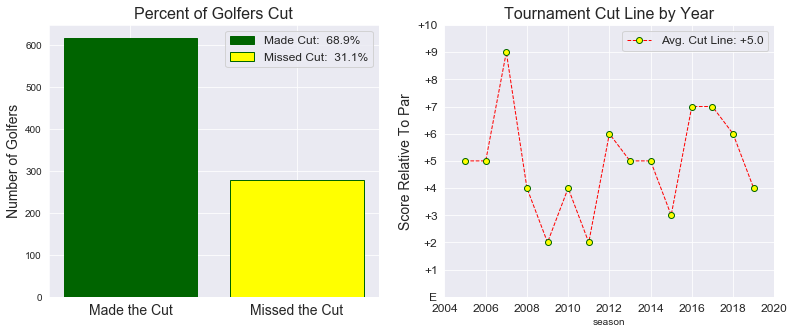

In [109]:
target_variable = 'made_cut'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Cut
height = df.groupby(target_variable).season.count().tolist()
missed_cut = height[0]
made_cut = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=made_cut,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Made Cut: {made_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Missed Cut: {missed_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.set_title("Percent of Golfers Cut", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Made the Cut', 'Missed the Cut'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper right', fontsize='large');

# Cutline overtime
avg_cutline = round(cut_lines['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

cut_lines.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Avg. Cut Line: +{avg_cutline}'
);
ax2.set_title("Tournament Cut Line by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.set_yticks(range(0, 11));
ax2.set_yticklabels(
    ('E', '+1', '+2', '+3', '+4',
     '+5', '+6', '+7', '+8', '+9', '+10')
);
ax2.set_xlim(2004, 2020);
ax2.legend(loc='upper right', fontsize='large');

### Top 10

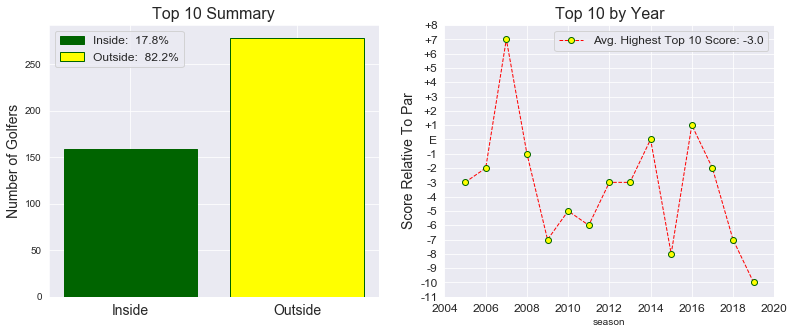

In [110]:
target_variable = 'top_10'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Inside Top 10
height = df.groupby(target_variable).season.count().tolist()
outside_top10 = height[0]
inside_top10 = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=inside_top10,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Inside: {inside_top10/(inside_top10+outside_top10) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Outside: {outside_top10/(inside_top10+outside_top10) : 0.1%}'
);
ax1.set_title("Top 10 Summary", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Inside', 'Outside'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper left', fontsize='large');

# Top 10 overtime
top_10 = pd.DataFrame(df[df[target_variable] == 1].groupby('season').total_score.max())
top_10.reset_index(drop=False, inplace=True)
top_10['season'] = top_10['season']+1
top_10['relative_to_par'] = top_10['total_score']-(72*4)
avg_top10 = round(top_10['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

top_10.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Avg. Highest Top 10 Score: {avg_top10}'
);
ax2.set_title("Top 10 by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');
ax2.set_yticks(range(-11, 9));
ax2.set_yticklabels(
    ('-11', '-10', '-9', '-8',
     '-7', '-6', '-5', '-4',
     '-3', '-2', '-1', 'E',
     '+1', '+2', '+3', '+4',
     '+5', '+6', '+7', '+8')
);
ax2.set_xlim(2004, 2020);

In [111]:
top10 = df[df['top_10'] == 1]
top10 = pd.DataFrame(top10['full_name'].value_counts())
top10.iloc[:5]

,full_name
tiger_woods,9
phil_mickelson,7
rory_mcilroy,5
lee_westwood,5
justin_rose,5


### Past Champions and Worst Performers

In [112]:
# Create a new dataframe that grabs golfers, their total experience, and number/pct of times they made the cut
experience = pd.DataFrame(df.groupby('full_name').experience.max())
experience.reset_index(drop=False, inplace=True)

cut_summary = pd.DataFrame(df.groupby('full_name').made_cut.sum())
cut_summary.reset_index(drop=False, inplace=True)

cut_summary = pd.merge(experience, cut_summary, how='outer', on='full_name')
cut_summary = cut_summary[['full_name', 'experience', 'made_cut']]
cut_summary['cuts_missed'] = cut_summary['experience'] - cut_summary['made_cut']
cut_summary['cuts_missed_pct'] = cut_summary['cuts_missed']/cut_summary['experience']*100
cut_summary = cut_summary[cut_summary['experience'] >= 4]

# Grab golfers that have missed more than 50% of cuts
augusta_hates = cut_summary[cut_summary['cuts_missed_pct'] >= 50]
raw_golfers = augusta_hates['full_name'].tolist()
golfers = [golfer.replace('_', ' ').title() for golfer in raw_golfers]
golfers = [golfer.replace('Iii', 'III') if golfer.endswith('Iii')
           else golfer for golfer in golfers]
augusta_hates['Golfers'] = golfers
augusta_hates.set_index('Golfers', inplace=True)
augusta_hates.sort_values(by='cuts_missed_pct', ascending=False, inplace=True)
augusta_hates

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,full_name,experience,made_cut,cuts_missed,cuts_missed_pct
Golfers,,,,,
Shaun Micheel,shaun_micheel,4,0,4,100.000000
Ben Curtis,ben_curtis,7,2,5,71.428571
Ben Crane,ben_crane,6,2,4,66.666667
Gary Woodland,gary_woodland,6,2,4,66.666667
Rory Sabbatini,rory_sabbatini,8,3,5,62.500000
Camilo Villegas,camilo_villegas,6,3,3,50.000000
Charles Howell III,charles_howell_iii,6,3,3,50.000000
Graeme Mcdowell,graeme_mcdowell,4,2,2,50.000000
John Senden,john_senden,6,3,3,50.000000


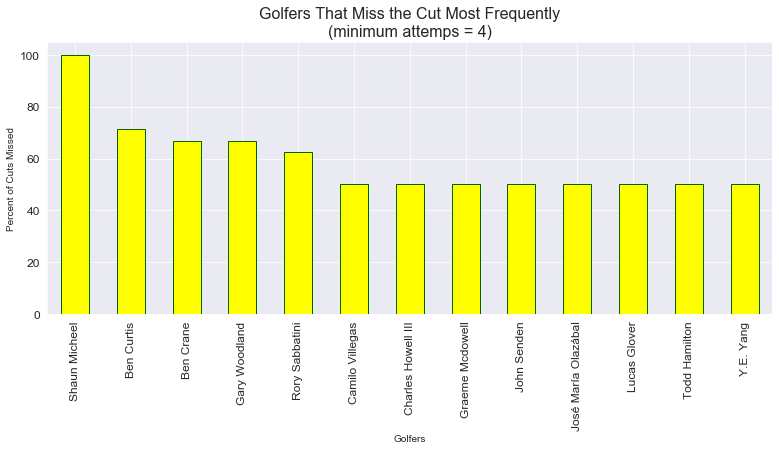

In [113]:
fig = plt.figure(figsize=(13,5));
ax = fig.add_subplot(111);
augusta_hates['cuts_missed_pct'].plot.bar(
    ax=ax,
    ec='darkgreen',
    fc='yellow',
    fontsize=12
);
ax.set_title(
    'Golfers That Miss the Cut Most Frequently\n(minimum attemps = 4)', 
    {'fontsize' : 16}
);
ax.set_ylabel('Percent of Cuts Missed');

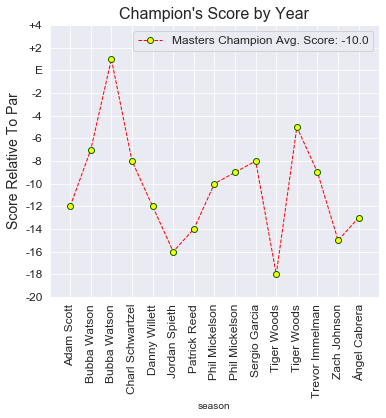

In [114]:
target_variable = 'champion'
title = 'Masters Champion'
fig = plt.figure(figsize=(13,5));

#Champion's score overtime
champion = pd.DataFrame(df[df[target_variable] == 1].groupby('season').total_score.max())
champion.reset_index(drop=False, inplace=True)
champion['season'] = champion['season']+1
champion['relative_to_par'] = champion['total_score']-(72*4)
avg_champion = round(champion['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

champion.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Masters Champion Avg. Score: {avg_champion}'
);
ax2.set_title("Champion's Score by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');
raw_champions = df[df['champion'] == 1].full_name.tolist()
champions = [champion.replace('_', ' ').title() for champion in raw_champions]
ax2.set_xticks(range(2005, 2020));
ax2.set_xticklabels(champions, rotation=90);
ax2.set_yticks(range(-20, 6, 2));
ax2.set_yticklabels(
    ('-20', '-18', '-16', '-14',
     '-12', '-10', '-8', '-6',
     '-4', '-2', 'E', '+2', '+4')
);
ax2.set_xlim(2004, 2020);

## Feature Exploration

### Strokes Gained Over Field

In [115]:
dataset = df[['season', 'full_name', 'experience', 'sg_roll_avg']]

exp1 = dataset[(dataset['experience'] < 6)].sg_roll_avg.mean()
exp2 = dataset[(dataset['experience'] > 5)&(dataset['experience'] < 11)].sg_roll_avg.mean()
exp3 = dataset[(dataset['experience'] > 11)].sg_roll_avg.mean()

print(exp1)
print(exp2)
print(exp3)

-3.9573254670599805
4.021072281959379
5.666734143049933


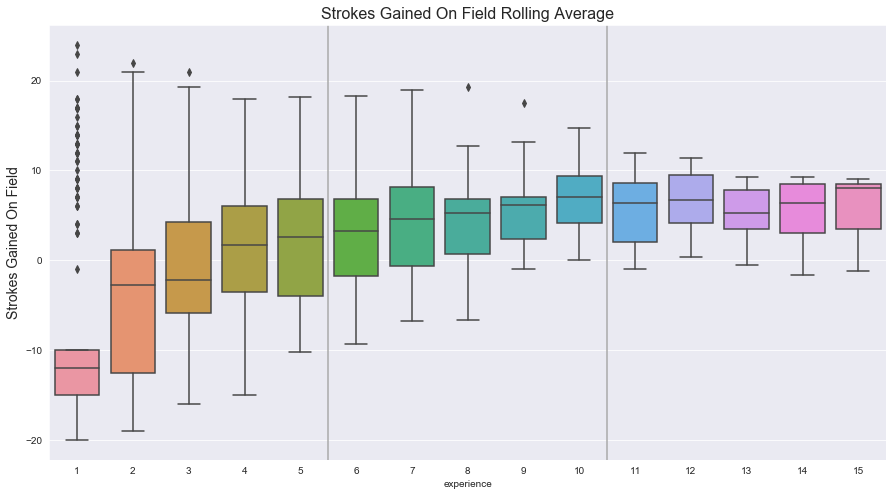

In [116]:
# Strokes Gained on field by experience
fig = plt.figure(figsize=figsize);
ax = fig.add_subplot(111);


sns.boxplot(
    x=dataset['experience'],
    y=dataset['sg_roll_avg']
);
ax.axvline(4.5, color='darkgray');
ax.axvline(9.5, color='darkgray');
ax.set_ylabel('Strokes Gained On Field', fontsize=14);
ax.set_title('Strokes Gained On Field Rolling Average', fontsize=16);

### Feature Correlations

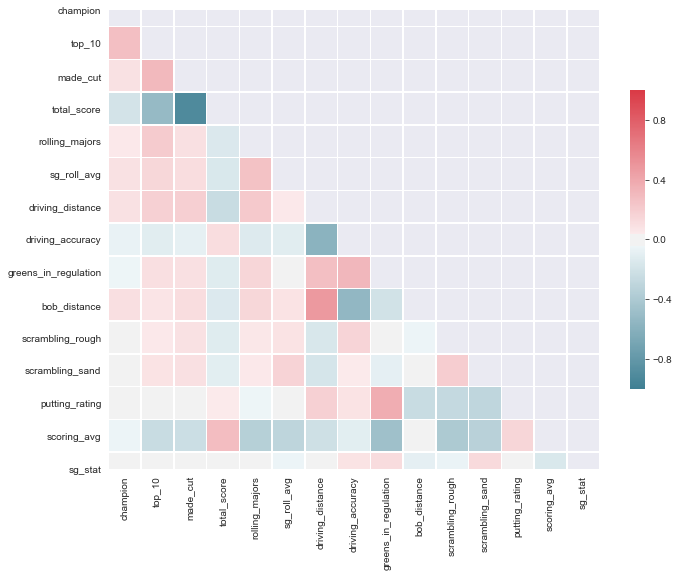

In [166]:
features = ['champion', 'top_10', 'made_cut', 'total_score',
            'rolling_majors', 'sg_roll_avg',
            'driving_distance', 'driving_accuracy',
            'greens_in_regulation', 'bob_distance',
            'scrambling_rough', 'scrambling_sand', 'putting_rating',
            'scoring_avg', 'sg_stat']

df_corr = df[features]

fig = plt.figure(figsize=(11,11))

# Create mask
mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create color scheme
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = fig.add_subplot(111)
sns.heatmap(df_corr.corr(),
            mask=mask, 
            cmap=cmap,
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5},
            ax=ax1);

### Test For Linearity

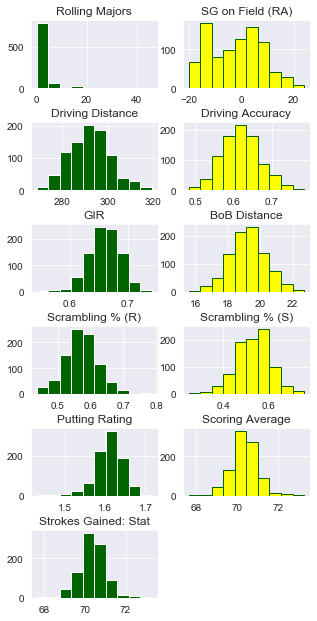

In [118]:
fig = plt.figure(figsize=(5, 20))
fig.subplots_adjust(hspace=hspace);

ax11 = fig.add_subplot(11,2,1);
ax11.hist(df['rolling_majors'], fc = 'darkgreen');
ax11.set_title('Rolling Majors');

ax12 = fig.add_subplot(11,2,2);
ax12.hist(df['sg_roll_avg'], fc='yellow', ec='darkgreen');
ax12.set_title('SG on Field (RA)');

ax13 = fig.add_subplot(11,2,3);
ax13.hist(df['driving_distance'], fc = 'darkgreen');
ax13.set_title('Driving Distance');

ax21 = fig.add_subplot(11,2,4);
ax21.hist(df['driving_accuracy'], fc='yellow', ec='darkgreen');
ax21.set_title('Driving Accuracy');

ax22 = fig.add_subplot(11,2,5);
ax22.hist(df['greens_in_regulation'], fc = 'darkgreen');
ax22.set_title('GIR');

ax23 = fig.add_subplot(11,2,6);
ax23.hist(df['bob_distance'], fc='yellow', ec='darkgreen');
ax23.set_title('BoB Distance');

ax31 = fig.add_subplot(11,2,7);
ax31.hist(df['scrambling_rough'], fc = 'darkgreen');
ax31.set_title('Scrambling % (R)');

ax32 = fig.add_subplot(11,2,8);
ax32.hist(df['scrambling_sand'], fc='yellow', ec='darkgreen');
ax32.set_title('Scrambling % (S)');

ax33 = fig.add_subplot(11,2,9);
ax33.hist(df['putting_rating'], fc = 'darkgreen');
ax33.set_title('Putting Rating');

ax41 = fig.add_subplot(11,2,10);
ax41.hist(df['scoring_avg'], fc='yellow', ec='darkgreen');
ax41.set_title('Scoring Average');

ax42 = fig.add_subplot(11,2,11);
ax42.hist(df['scoring_avg'], fc = 'darkgreen');
ax42.set_title('Strokes Gained: Stat');

## Drop EDA Only Features

In [50]:
# Define drop list
drop = ['experience', 'prior_score', 'ps_roll_avg', 'prior_afs', 'sg_on_field']
df = df.drop(drop, axis=1)

# Examine new dataframe
print(df.shape)
df.head()

(895, 17)


,full_name,season,champion,top_10,made_cut,total_score,sg_roll_avg,rolling_majors,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,sg_stat
0,aaron_baddeley,2006,0,0,1,307,-13.000000,0.0,288.3,0.6073,0.5826,21.326667,0.6100,0.5271,1.553,71.197,0.999697
1,aaron_baddeley,2007,0,0,0,315,-7.500000,0.0,291.9,0.6000,0.6035,21.005830,0.6021,0.5905,1.570,70.088,0.994052
2,aaron_baddeley,2008,0,0,1,284,-9.333333,0.0,290.3,0.5945,0.6202,21.109307,0.5549,0.5694,1.577,70.196,0.999667
3,aaron_baddeley,2010,0,0,1,293,-10.750000,0.0,298.9,0.5665,0.6460,21.237521,0.5458,0.5766,1.587,70.995,1.001072
4,aaron_baddeley,2011,0,0,1,293,-7.400000,0.0,296.2,0.5567,0.6548,21.490982,0.4932,0.5673,1.536,70.230,1.005012


# Model Training and Predictions

## Making the Cut Classifier

### Define Key Variables

In [51]:
# Random state
SEED = 13

# Split
test_size = 0.2

# Labels
target_names = ['missed_cut', 'made_cut']

FI_labels = df.drop(['full_name', 'season', 'champion',
                     'top_10', 'made_cut', 'total_score'], axis=1).columns.values

# K-folds Cross Validation
cv = 3

# Evaluation metric
scoring = 'f1'

# Train, Test, and Split
X = df.drop(['full_name', 'season', 'champion',        
             'top_10', 'made_cut', 'total_score'], axis=1)

y = df['made_cut']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# We will use smote to handle our class imbalance
smt = SMOTE(random_state=SEED)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [52]:
print('Feature Summary')
print(f'No. of Features: {len(X_train.columns.values)}')
print(f'Features: {X_train.columns.values}')

Feature Summary
No. of Features: 11
Features: ['sg_roll_avg' 'rolling_majors' 'driving_distance' 'driving_accuracy'
 'greens_in_regulation' 'bob_distance' 'scrambling_rough'
 'scrambling_sand' 'putting_rating' 'scoring_avg' 'sg_stat']


In [53]:
print('Class Summary:')
print('--'*20)
y_train.value_counts(normalize=True)

Class Summary:
----------------------------------------


1    0.5
0    0.5
Name: made_cut, dtype: float64

### Base Model

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    5.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.0s finished


------------------------------------------------------
Dummy Classifier Model Best Params:
------------------------------------------------------
 strategy : uniform
------------------------------------------------------
Dummy Classifier Model F1 Scores:
------------------------------------------------------
 train:  48.52%
 test:  62.04%
------------------------------------------------------
Dummy Classifier Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.35      0.54      0.42        56
    made_cut       0.72      0.54      0.62       123

    accuracy                           0.54       179
   macro avg       0.53      0.54      0.52       179
weighted avg       0.60      0.54      0.56       179

------------------------------------------------------


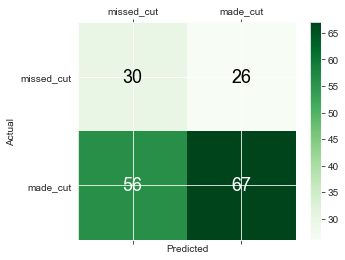

['models/noSG/base_model.pkl']

In [123]:
# Instantiate classifier and define model
classifier = DummyClassifier(random_state = SEED)
model_name = 'Dummy Classifier Model'

# Create param grid for GridSearch
param_grid = {'strategy' : ['uniform','stratified']}

# Instantiate GridSearch
dummy_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dummy_clf.fit(X_train, y_train)
y_hat_pred = dummy_clf.predict(X_train)
y_pred = dummy_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dummy_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/base_model.pkl'
model = dummy_clf
joblib.dump(model, filename)

### Logistic Regression

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 263 out of 270 | elapsed:   30.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   39.3s finished
/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


------------------------------------------------------
Logistic Regression Model Best Params:
------------------------------------------------------
 classifier__C : 100000.0
 classifier__penalty : l1
 classifier__solver : liblinear
 pca__n_components : 11
------------------------------------------------------
Logistic Regression Model F1 Scores:
------------------------------------------------------
 train:  60.73%
 test:  73.68%
------------------------------------------------------
Logistic Regression Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.47      0.62      0.54        56
    made_cut       0.80      0.68      0.74       123

    accuracy                           0.66       179
   macro avg       0.64      0.65      0.64       179
weighted avg       0.70      0.66      0.67       179

------------------------------------------------------


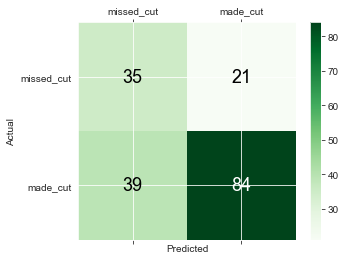

['models/noSG/log_model.pkl']

In [124]:
# Instantiate classifier and pipeline
model_name = 'Logistic Regression Model'
classifier = LogisticRegression(max_iter=1000, random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' :[3, 6, 11],
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'classifier__C' : np.logspace(-10,10,5),
}

# Instantiate GridSearch
log_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = log_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/log_model.pkl'
model = log_clf
joblib.dump(model, filename)

In [125]:
# Print Logistic Regression Model
log_optimized = LogisticRegression(
    penalty = best_params['classifier__penalty'],
    solver = best_params['classifier__solver'],
    C = best_params['classifier__C']
)

log_optimized.fit(X_train, y_train)

print(f'Intercept: {log_optimized.intercept_}')
print(f'Coefficients: {log_optimized.coef_}')

Intercept: [-0.05482151]
Coefficients: [[ 1.53937120e-02  6.98252449e-02  1.85737839e-04 -2.43305483e-01
   7.90236121e-02  6.01952041e-03  1.80577991e-01  2.81893982e-01
  -5.79129229e-02 -2.87377083e-03 -5.18350513e-11]]


### Decision Tree

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    1.9s finished


------------------------------------------------------
Decision Tree Model Best Params:
------------------------------------------------------
 classifier__criterion : gini
 classifier__max_depth : 7
 classifier__min_samples_leaf : 5
 classifier__min_samples_split : 5
 pca__n_components : 6
------------------------------------------------------
Decision Tree Model F1 Scores:
------------------------------------------------------
 train:  77.89%
 test:  73.19%
------------------------------------------------------
Decision Tree Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.45      0.54      0.49        56
    made_cut       0.77      0.70      0.73       123

    accuracy                           0.65       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.67      0.65      0.66       179

------------------------------------------------------


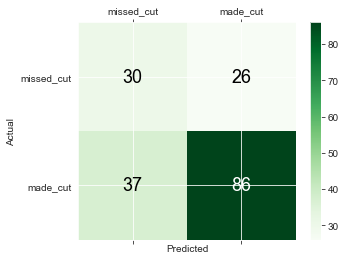

['models/noSG/dt_model.pkl']

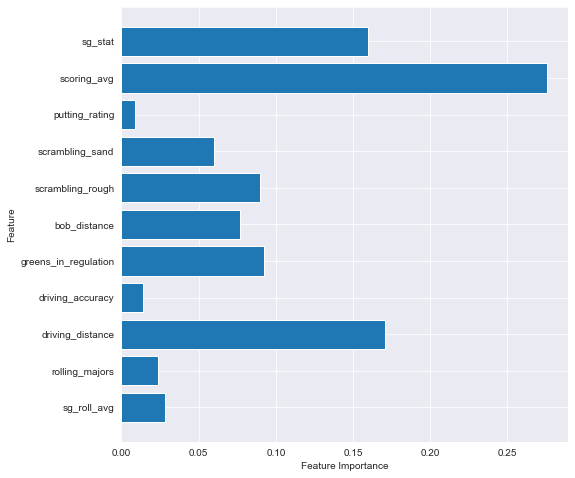

In [126]:
# Instantiate classifier and define model
model_name = 'Decision Tree Model'
classifier = DecisionTreeClassifier(random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' :[3, 6, 11],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [2, 5, 7],
    'classifier__min_samples_split' : [5, 10],
    'classifier__min_samples_leaf' : [5, 10]
}

# Instantiate GridSearch
dt_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dt_clf.fit(X_train, y_train)
y_hat_pred = dt_clf.predict(X_train)
y_pred = dt_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dt_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
dt_optimized = DecisionTreeClassifier(
    criterion = best_params['classifier__criterion'],
    max_depth = best_params['classifier__max_depth'],
    min_samples_split = best_params['classifier__min_samples_split'],
    min_samples_leaf = best_params['classifier__min_samples_leaf'],
    random_state = SEED
)

dt_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/dt_model.pkl'
model = dt_clf
joblib.dump(model, filename)

### Random Forest

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.0s finished


------------------------------------------------------
Random Forest Model Best Params:
------------------------------------------------------
 classifier__criterion : gini
 classifier__max_depth : 6
 classifier__max_features : auto
 classifier__min_samples_leaf : 6
 classifier__min_samples_split : 6
 classifier__n_estimators : 100
 pca__n_components : 11
------------------------------------------------------
Random Forest Model F1 Scores:
------------------------------------------------------
 train:  83.92%
 test:  76.03%
------------------------------------------------------
Random Forest Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.48      0.52      0.50        56
    made_cut       0.77      0.75      0.76       123

    accuracy                           0.68       179
   macro avg       0.63      0.63      0.63       179
weighted avg       0.68      0.68      0.68   

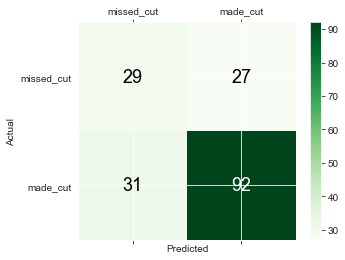

['models/noSG/rf_model.pkl']

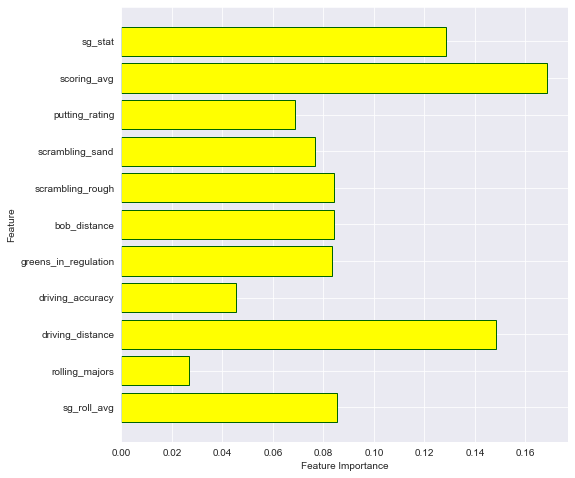

In [54]:
# Instantiate classifier and define model
model_name = 'Random Forest Model'
classifier = RandomForestClassifier(random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' :[11],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__n_estimators' : [100],
    'classifier__max_features' : ['auto'],
    'classifier__max_depth' : [6],
    'classifier__min_samples_split' : [6],
    'classifier__min_samples_leaf' : [6]
}

# Instantiate GridSearch
rf_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rf_clf.fit(X_train, y_train)
y_hat_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rf_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
rf_optimized = RandomForestClassifier(
    criterion = best_params['classifier__criterion'],
    n_estimators = best_params['classifier__n_estimators'],
    max_features = best_params['classifier__max_features'],
    max_depth = best_params['classifier__max_depth'],
    min_samples_split = best_params['classifier__min_samples_split'],
    min_samples_leaf = best_params['classifier__min_samples_leaf'],
    random_state = SEED
)

rf_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, rf_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/rf_model.pkl'
model = rf_clf
joblib.dump(model, filename)

### AdaBoost

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   12.8s finished


------------------------------------------------------
AdaBoost Model Best Params:
------------------------------------------------------
 classifier__learning_rate : 0.5
 classifier__n_estimators : 200
 pca__n_components : 11
------------------------------------------------------
AdaBoost Model F1 Scores:
------------------------------------------------------
 train:  78.17%
 test:  73.86%
------------------------------------------------------
AdaBoost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.44      0.48      0.46        56
    made_cut       0.75      0.72      0.74       123

    accuracy                           0.65       179
   macro avg       0.60      0.60      0.60       179
weighted avg       0.66      0.65      0.65       179

------------------------------------------------------


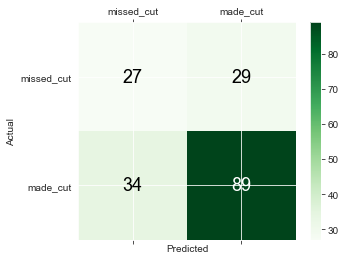

['models/noSG/ab_model.pkl']

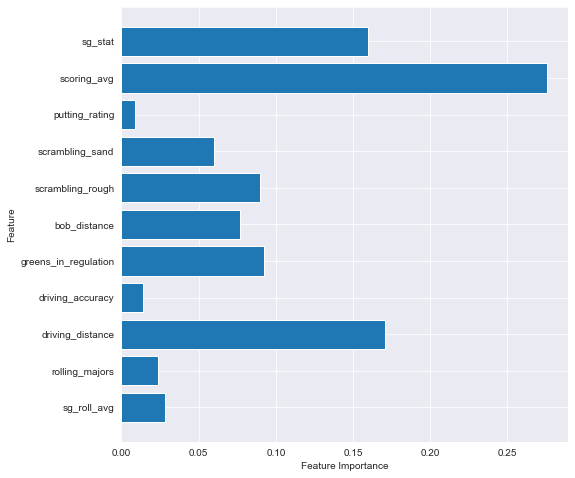

In [128]:
# Instantiate classifier and define model
model_name = 'AdaBoost Model'
classifier = AdaBoostClassifier(random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : [3, 6, 11],
    'classifier__n_estimators' : [150, 200],
    'classifier__learning_rate' : [0.4, 0.5, 0.6],
}

# Instantiate GridSearch
ab_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ab_clf.fit(X_train, y_train)
y_hat_pred = ab_clf.predict(X_train)
y_pred = ab_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ab_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(ab_clf, X_test, y_test);

# Feature importance
ab_optimized = AdaBoostClassifier(
    n_estimators = best_params['classifier__n_estimators'],
    learning_rate = best_params['classifier__learning_rate'],
    random_state = SEED
)

ab_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/ab_model.pkl'
model = ab_clf
joblib.dump(model, filename)

### Gradient Boost

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    8.6s finished


------------------------------------------------------
Gradient Boost Model Best Params:
------------------------------------------------------
 classifier__learning_rate : 0.2
 classifier__n_estimators : 100
 pca__n_components : 11
------------------------------------------------------
Gradient Boost Model F1 Scores:
------------------------------------------------------
 train:  96.29%
 test:  75.59%
------------------------------------------------------
Gradient Boost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.44      0.38      0.40        56
    made_cut       0.73      0.78      0.76       123

    accuracy                           0.65       179
   macro avg       0.59      0.58      0.58       179
weighted avg       0.64      0.65      0.65       179

------------------------------------------------------


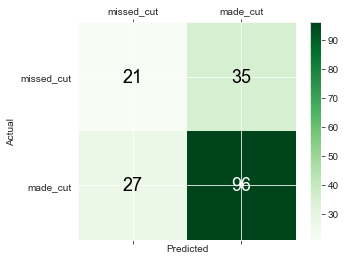

['models/noSG/gb_model.pkl']

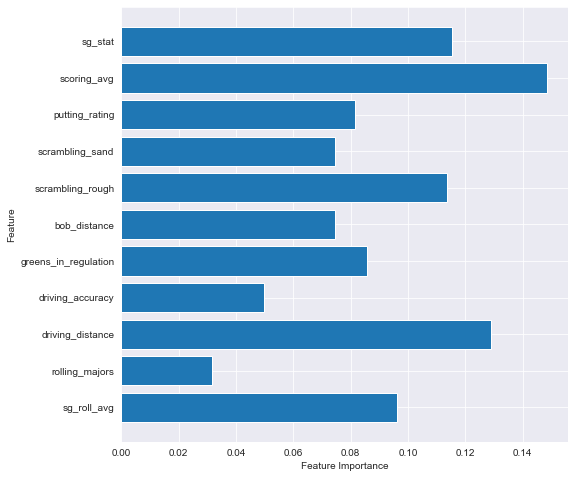

In [129]:
# Instantiate classifier and define model
model_name = 'Gradient Boost Model'
classifier = GradientBoostingClassifier(random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : [3, 6, 11],
    'classifier__n_estimators' : [75, 100, 125],
    'classifier__learning_rate' : [0.1, 0.2, 0.3],
}

# Instantiate GridSearch
gb_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gb_clf.fit(X_train, y_train)
y_hat_pred = gb_clf.predict(X_train)
y_pred = gb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gb_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
gb_optimized = GradientBoostingClassifier(
    n_estimators = best_params['classifier__n_estimators'],
    learning_rate = best_params['classifier__learning_rate'],
    random_state = SEED
)

gb_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, gb_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/gb_model.pkl'
model = gb_clf
joblib.dump(model, filename)

### Results Summary

In [130]:
classifiers = [dummy_clf, log_clf, dt_clf, rf_clf, ab_clf, gb_clf]
names = ['base', 'log_reg', 'decTree', 'randomF', 'adaB', 'gradB']
class_results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['accuracy'] = round(metrics.accuracy_score(y_test, y_pred)*100,2)
    result['precision'] = round(metrics.precision_score(y_test, y_pred)*100,2)
    result['recall'] = round(metrics.recall_score(y_test, y_pred)*100,2)
    result['f1'] = round(metrics.f1_score(y_test, y_pred)*100,2)
    class_results.append(result)

class_results_df = pd.DataFrame(class_results)

print(class_results_df.shape)
class_results_df

(6, 5)


,model,accuracy,precision,recall,f1
0,base,54.19,72.04,54.47,62.04
1,log_reg,66.48,80.00,68.29,73.68
2,decTree,64.80,76.79,69.92,73.19
3,randomF,67.60,77.31,74.80,76.03
4,adaB,64.80,75.42,72.36,73.86
5,gradB,65.36,73.28,78.05,75.59


## Final Score Regressor

### Define Key Variables

In [131]:
# Define drop list
drop = ['full_name', 'season', 'champion', 'top_10', 'made_cut', 'total_score']

# Train, test, split
X = df.drop(drop, axis=1)
y = df['total_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

In [132]:
print('Dependent Variable Summary')
print(f'No. of Dependent Variables: {len(X_train.columns.values)}')
print(f'Dependent Variables: {X_train.columns.values}')

Dependent Variable Summary
No. of Dependent Variables: 11
Dependent Variables: ['sg_roll_avg' 'rolling_majors' 'driving_distance' 'driving_accuracy'
 'greens_in_regulation' 'bob_distance' 'scrambling_rough'
 'scrambling_sand' 'putting_rating' 'scoring_avg' 'sg_stat']


In [133]:
#Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Ridge Regression

In [134]:
# Ridge
model_name = 'Ridge Regression'
classifier = Ridge()
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : range(1, 12),
    'classifier__alpha' : [0.1, 0.2, 0.5, 1]
}

# Instantiate GridSearch
ridge = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ridge.fit(X_train, y_train)
y_h_ridge_train = ridge.predict(X_train)
y_h_ridge_test = ridge.predict(X_test)
train_ridge_mse = np.sum((y_train - y_h_ridge_train)**2)/df.shape[0]
train_ridge_r2 = metrics.r2_score(y_train, y_h_ridge_train)
test_ridge_mse = np.sum((y_test - y_h_ridge_test)**2)/df.shape[0]
test_ridge_r2 = metrics.r2_score(y_test, y_h_ridge_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ridge.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print rMSE and R2 results
print('--'*27)
print(f'{model_name} Error and Scores:')
print('--'*27)
print(f' Train rMSE: {round(np.sqrt(train_ridge_mse), 4)} | Train R2: {round(train_ridge_r2, 4)}')
print(f' Test  rMSE: {round(np.sqrt(test_ridge_mse), 4)}  | Test  R2: {round(test_ridge_r2, 4)}')
print('--'*27)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


------------------------------------------------------
Ridge Regression Best Params:
------------------------------------------------------
 classifier__alpha : 1
 pca__n_components : 11
------------------------------------------------------
Ridge Regression Error and Scores:
------------------------------------------------------
 Train rMSE: 11.0756 | Train R2: 0.1271
 Test  rMSE: 5.5302  | Test  R2: 0.1398
------------------------------------------------------


[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.6s finished


### Lasso Regression

In [135]:
# Lasso
model_name = 'Lasso Regression'
classifier = Lasso()
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : range(1, 12),
    'classifier__alpha' : [0.1, 0.2, 0.5, 1]
}

# Instantiate GridSearch
lasso = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
lasso.fit(X_train, y_train)
y_h_lasso_train = lasso.predict(X_train)
y_h_lasso_test = lasso.predict(X_test)
train_lasso_mse = np.sum((y_train - y_h_lasso_train)**2)/df.shape[0]
train_lasso_r2 = metrics.r2_score(y_train, y_h_lasso_train)
test_lasso_mse = np.sum((y_test - y_h_lasso_test)**2)/df.shape[0]
test_lasso_r2 = metrics.r2_score(y_test, y_h_lasso_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = lasso.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print rMSE and R2 results
print('--'*27)
print(f'{model_name} Error and Scores:')
print('--'*27)
print(f' Train rMSE: {round(np.sqrt(train_lasso_mse), 4)} | Train R2: {round(train_lasso_r2, 4)}')
print(f' Test  rMSE: {round(np.sqrt(test_lasso_mse), 4)}  | Test  R2: {round(test_lasso_r2, 4)}')
print('--'*27)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 44 candidates, totalling 132 fits
------------------------------------------------------
Lasso Regression Best Params:
------------------------------------------------------
 classifier__alpha : 0.1
 pca__n_components : 11
------------------------------------------------------
Lasso Regression Error and Scores:
------------------------------------------------------
 Train rMSE: 11.0821 | Train R2: 0.1261
 Test  rMSE: 5.5286  | Test  R2: 0.1403
------------------------------------------------------


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.6s finished


### Unpenalized Linear Regression

In [136]:
# Linear
model_name = 'Linear Regression'
classifier = LinearRegression()
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {'pca__n_components' : range(1, 12)}

# Instantiate GridSearch
linear = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
linear.fit(X_train, y_train)
y_h_linear_train = linear.predict(X_train)
y_h_linear_test = linear.predict(X_test)
train_linear_mse = np.sum((y_train - y_h_linear_train)**2)/df.shape[0]
train_linear_r2 = metrics.r2_score(y_train, y_h_linear_train)
test_linear_mse = np.sum((y_test - y_h_linear_test)**2)/df.shape[0]
test_linear_r2 = metrics.r2_score(y_test, y_h_linear_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = linear.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print rMSE and R2 results
print('--'*27)
print(f'{model_name} Error and Scores:')
print('--'*27)
print(f' Train rMSE: {round(np.sqrt(train_linear_mse), 4)} | Train R2: {round(train_linear_r2, 4)}')
print(f' Test  rMSE: {round(np.sqrt(test_linear_mse), 4)}  | Test  R2: {round(test_linear_r2, 4)}')
print('--'*27)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.2s finished


------------------------------------------------------
Linear Regression Best Params:
------------------------------------------------------
 pca__n_components : 10
------------------------------------------------------
Linear Regression Error and Scores:
------------------------------------------------------
 Train rMSE: 11.1179 | Train R2: 0.1204
 Test  rMSE: 5.5242  | Test  R2: 0.1416
------------------------------------------------------


### Random Forest Regression

In [175]:
# Random Forest
model_name = 'Random Forest Regression'
classifier = RandomForestRegressor(criterion='mse', random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : [11],
    'classifier__n_estimators' : [30, 40],
    'classifier__max_features' : ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [2, 5],
    'classifier__min_samples_split' : [25, 50],
    'classifier__min_samples_leaf' : [25, 50]
}

# Instantiate GridSearch
rfr = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rfr.fit(X_train, y_train)
y_h_rfr_train = rfr.predict(X_train)
y_h_rfr_test = rfr.predict(X_test)
train_rfr_mse = np.sum((y_train - y_h_rfr_train)**2)/df.shape[0]
train_rfr_r2 = metrics.r2_score(y_train, y_h_rfr_train)
test_rfr_mse = np.sum((y_test - y_h_rfr_test)**2)/df.shape[0]
test_rfr_r2 = metrics.r2_score(y_test, y_h_rfr_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rfr.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print rMSE and R2 results
print('--'*27)
print(f'{model_name} Error and Scores:')
print('--'*27)
print(f' Train rMSE: {round(np.sqrt(train_rfr_mse), 4)} | Train R2: {round(train_rfr_r2, 4)}')
print(f' Test  rMSE: {round(np.sqrt(test_rfr_mse), 4)}  | Test  R2: {round(test_rfr_r2, 4)}')
print('--'*27)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.7s


------------------------------------------------------
Random Forest Regression Best Params:
------------------------------------------------------
 classifier__max_depth : 5
 classifier__max_features : auto
 classifier__min_samples_leaf : 25
 classifier__min_samples_split : 25
 classifier__n_estimators : 30
 pca__n_components : 11
------------------------------------------------------
Random Forest Regression Error and Scores:
------------------------------------------------------
 Train rMSE: 0.4496 | Train R2: 0.2677
 Test  rMSE: 0.2031  | Test  R2: 0.0403
------------------------------------------------------


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    7.0s finished


### Gradient Boost Regression

In [138]:
# Gradient Boosting
model_name = 'Gradient Boost Regression'
classifier = HistGradientBoostingRegressor(loss='least_squares', random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : [1, 2, 3],
    'classifier__l2_regularization' : np.logspace(-5,5,5),
    'classifier__max_depth' : [2, 5],
    'classifier__learning_rate' : [0.1, 0.2, 0.5]
}

# Instantiate GridSearch
gbr = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gbr.fit(X_train, y_train)
y_h_gbr_train = gbr.predict(X_train)
y_h_gbr_test = gbr.predict(X_test)
train_gbr_mse = np.sum((y_train - y_h_gbr_train)**2)/df.shape[0]
train_gbr_r2 = metrics.r2_score(y_train, y_h_gbr_train)
test_gbr_mse = np.sum((y_test - y_h_gbr_test)**2)/df.shape[0]
test_gbr_r2 = metrics.r2_score(y_test, y_h_gbr_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gbr.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print rMSE and R2 results
print('--'*27)
print(f'{model_name} Error and Scores:')
print('--'*27)
print(f' Train rMSE: {round(np.sqrt(train_gbr_mse), 4)} | Train R2: {round(train_gbr_r2, 4)}')
print(f' Test  rMSE: {round(np.sqrt(test_gbr_mse), 4)}  | Test  R2: {round(test_gbr_r2, 4)}')
print('--'*27)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 263 out of 270 | elapsed:   11.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   11.9s finished


------------------------------------------------------
Gradient Boost Regression Best Params:
------------------------------------------------------
 classifier__l2_regularization : 316.22776601683796
 classifier__learning_rate : 0.2
 classifier__max_depth : 2
 pca__n_components : 3
------------------------------------------------------
Gradient Boost Regression Error and Scores:
------------------------------------------------------
 Train rMSE: 10.7561 | Train R2: 0.1767
 Test  rMSE: 5.6858  | Test  R2: 0.0907
------------------------------------------------------


### Results Summary

In [168]:
classifiers = [ridge, lasso, linear, rfr, gbr]
names = ['ridge', 'lasso', 'unpenalized', 'randomF', 'gradB']
reg_results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['train_mse'] = round(np.sqrt(np.sum((y_train - y_hat_pred)**2)/df.shape[0]), 4)
    result['train_r2'] = round(metrics.r2_score(y_train, y_hat_pred), 4)
    result['test_mse'] = round(np.sqrt(np.sum((y_test - y_pred)**2)/df.shape[0]), 4)
    result['test_r2'] = round((metrics.r2_score(y_test, y_pred)) ,4)
    reg_results.append(result)

reg_results_df = pd.DataFrame(reg_results)

print(reg_results_df.shape)
reg_results_df

(5, 5)


,model,train_mse,train_r2,test_mse,test_r2
0,ridge,4.349107e+09,-6.853720e+19,246.7542,-1.416158e+06
1,lasso,2.922110e+09,-3.093992e+19,202.1092,-9.500677e+05
2,unpenalized,4.882567e+09,-8.638184e+19,14.6552,-4.994355e+03
3,randomF,4.496000e-01,2.677000e-01,0.2031,4.030000e-02
4,gradB,3.082044e+02,-3.441934e+05,131.1003,-3.997506e+05


## Prediction Pipeline

### Make a Prediction

In [176]:
years = range(2012, 2020)
rfr = RandomForestRegressor(
    criterion = 'mse',
    n_estimators = best_params['classifier__n_estimators'],
    max_features = best_params['classifier__max_features'],
    max_depth = best_params['classifier__max_depth'],
    min_samples_split = best_params['classifier__min_samples_split'],
    min_samples_leaf = best_params['classifier__min_samples_leaf'],
)

for year in years:
    # Load holdout and test_df datasets
    holdout = pd.read_csv(f'csv_files/holdouts/{year}/holdout_data.csv', index_col=0)
    test_df = pd.read_csv(f'csv_files/holdouts/{year}/test_df_data.csv', index_col=0)

    # Define X, y, and X_holdout
    test_df.drop(['experience', 'prior_score', 'ps_roll_avg',
                  'prior_afs', 'sg_on_field'], axis=1, inplace=True)
    holdout.drop(['experience', 'prior_score', 'ps_roll_avg',
                  'prior_afs', 'sg_on_field'], axis=1, inplace=True)

    X = test_df.drop(['full_name', 'season', 'champion',  
                      'top_10', 'made_cut', 'total_score'], axis=1)
    y = test_df['made_cut']
    X_holdout = holdout.drop(['full_name', 'season', 'champion',
                              'top_10', 'made_cut', 'total_score'], axis=1)

    # Refit classifier and predict which golfers will make the cut
    rf_optimized = rf_optimized.fit(X, y)
    cut_predictions = rf_optimized.predict(X_holdout)

    # Define desired features
    desired_features = ['full_name', 'rolling_majors', 'sg_roll_avg',
                        'driving_distance', 'driving_accuracy',
                        'greens_in_regulation', 'bob_distance',
                        'scrambling_rough', 'scrambling_sand',
                        'putting_rating', 'scoring_avg', 'sg_stat']

    # Create new dataframe with features used in regression to predict if golferd final score
    masters_field = pd.DataFrame(holdout[desired_features])

    # Add predictions to the new dataframe
    masters_field['made_cut'] = cut_predictions

    # Define weekend_field, X, y, and X_weekend
    weekend_field = masters_field[masters_field['made_cut'] == 1]
    X = test_df.drop(['full_name', 'season', 'champion',
                              'top_10', 'made_cut', 'total_score'], axis=1)
    y = test_df['total_score']
    X_weekend = weekend_field.drop(['full_name', 'made_cut'], axis=1)

    # Standarize Data
    X = scaler.fit_transform(X)
    X_weekend = scaler.transform(X_weekend)

    # Refit regression model and predict scores based on predicted weekend field
    rfr = rfr.fit(X, y)
    predictions = rfr.predict(X_weekend)
    weekend_field['predicted_score'] = predictions
    results = weekend_field[['full_name', 'predicted_score']]
    results.sort_values(by='predicted_score', inplace=True)
    results.to_csv(f'csv_files/holdouts/{year}/final_score_predictions.csv')

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

### 2020 Prediction Results

In [177]:
results

,full_name,predicted_score
450,justin_thomas,285.039569
616,patrick_cantlay,285.320050
710,rory_mcilroy,285.488093
113,brooks_koepka,285.895689
411,jon_rahm,288.114001
24,adam_scott,289.423506
230,dustin_johnson,289.505764
874,tony_finau,289.524039
918,xander_schauffele,289.847051
302,hideki_matsuyama,290.032625


# Back-Tested Results

In [ ]:
dataset = pd.read_csv('csv_files/masters_results - results.csv')
dataset['accuracy'] = dataset['accuracy']*100
print(dataset.shape)
dataset

In [5]:
dataset.groupby('tournament_year').accuracy.mean()

tournament_year
2013    30.0
2014    10.0
2015    20.0
2016    50.0
2017    40.0
2018    50.0
2019    50.0
Name: accuracy, dtype: float64

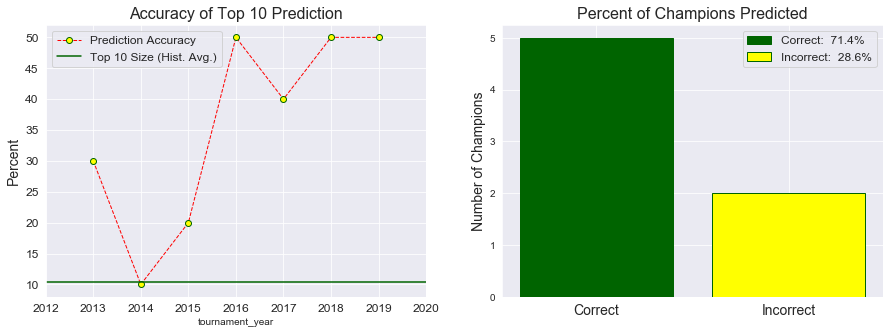

In [11]:
fig = plt.figure(figsize=(15,5));

ax1 = fig.add_subplot(121);
dataset.groupby('tournament_year').accuracy.mean().plot(
    kind='line',
    ax=ax1,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label='Prediction Accuracy'
);
x = (10/96)*100
ax1.axhline(x, color='darkgreen', label='Top 10 Size (Hist. Avg.)');
ax1.set_title('Accuracy of Top 10 Prediction', {'fontsize' : 16});
ax1.set_ylabel('Percent', {'fontsize' : 14});
ax1.set_xlim(2012, 2020);
ax1.legend(loc='upper left', fontsize='large');

# Percent of Golfers Cut
height = dataset.groupby('winner_correct').tournament_year.count().tolist()
incorrect = height[0]
correct = height[1]
ax2 = fig.add_subplot(122);
ax2.bar(
    x=0, 
    height=correct,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Correct: {correct/(correct+incorrect) : 0.1%}'
);
ax2.bar(
    x=1, 
    height=incorrect,
    ec='darkgreen',
    fc='yellow',
    label=f'Incorrect: {incorrect/(correct+incorrect) : 0.1%}'
);
ax2.set_title("Percent of Champions Predicted", {'fontsize' : 16});
ax2.set_ylabel('Number of Champions', {'fontsize' : 14});
ax2.set_xticks(ticks=[0,1]);
ax2.set_xticklabels(labels=['Correct', 'Incorrect'], fontdict={'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');